<a href="https://colab.research.google.com/github/samejain1983/Loan_Status_Prediction_Case_Study/blob/main/Copy_of_Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

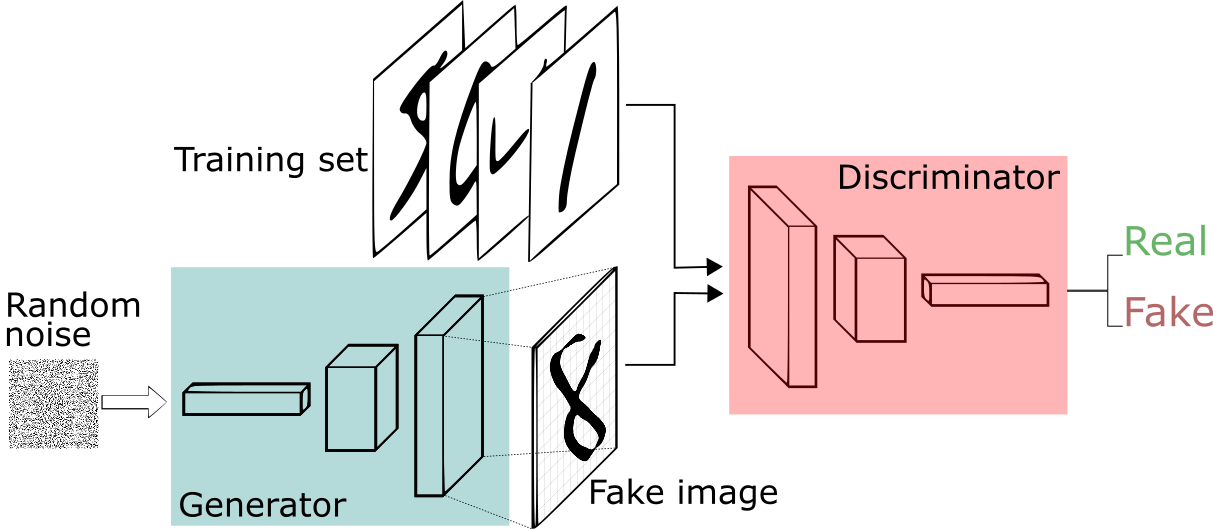

In [7]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [1]:
device = 'cuda' #image = image.to(device)
batch_size = 128 #trainloader, training loop
noise_dim = 64 #generator model

#optimizers parameters

lr=.0002
beta_1 = 0.5
beta_2 = 0.99

#Training variables

epochs = 20

# Load MNIST Dataset

In [3]:
from torchvision import datasets, transforms as T

train_augs = T.Compose([T.RandomRotation((-20,+20)),
                        T.ToTensor() #(h,w,c) -> (c,h,w)
])

trainset = datasets.MNIST('MNIST/',download = True, train=True, transform = train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 121006662.88it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42925476.20it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31402326.59it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6377813.45it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



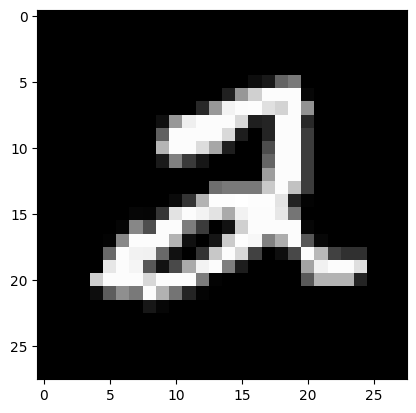

In [10]:
image, label = trainset[5]
plt.imshow(image.squeeze(), cmap='gray')  # Fix the typo in squeeze()
plt.show()  # Add plt.show() to display the image


In [11]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle = True)

print("Total no. of batches in trainloader : ", len(trainloader))

Total no. of batches in trainloader :  469


In [16]:
dataiter = iter(trainloader)
images, _ = dataiter.__next__()  # Use __next__() instead of next()
print(images.shape)
# Output should be torch.Size([128, 1, 28, 28])


torch.Size([128, 1, 28, 28])


# Load Dataset Into Batches

In [17]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

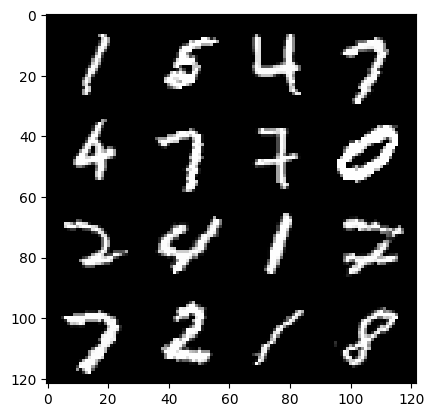

In [18]:

show_tensor_images(images, num_images=16)

# Create Discriminator Network

In [27]:
#In case if torch summary is not installed

from torch import nn
from torchsummary import summary

In [28]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [36]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
  )

In [37]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3, 3), 2)
        self.block_2 = get_disc_block(16, 32, (5, 5), 2)
        self.block_3 = get_disc_block(32, 64, (5, 5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.flatten(x3)
        x5 = self.linear(x4)
        return x5

# Correct instantiation of the Discriminator
D = Discriminator()
D.to(device)

# Assuming you have a function get_disc_block defined elsewhere
# You may also need to import it if it's not part of this script.

# Assuming you have the torchsummary library installed
summary(D, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [41]:
import torch.nn as nn
from torchsummary import summary

def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3, 3), 2)
        self.block_2 = get_gen_block(256, 128, (4, 4), 1)
        self.block_3 = get_gen_block(128, 64, (3, 3), 2)
        self.block_4 = get_gen_block(64, 1, (4, 4), 2, final_block=True)

    def forward(self, r_noise_vec):
        # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)

        return x4

# Correct instantiation of the Generator
G = Generator(noise_dim)
G.to(device)

# Assuming you have the torchsummary library installed
summary(G, input_size=(1, noise_dim))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [42]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# Create Loss Function and Load Optimizer

In [43]:
def real_loss(disc_pred):
	criterion = nn.BCEWithLogitsLoss()
	ground_truth = torch.ones_like(disn_pred)
	loss = criterion(disc_pred, ground_truth)
	return loss

def fake_loss(disc_pred):
	criterion = nn.BCEWithLogitsLoss()
	ground_truth = torch.zeros_like(disc_pred)
	loss = criterion(disc_pred, ground_truth)
	return loss

D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas =(beta_1, beta_2))

# Training Loop

Epoch : 1 | D_loss : 0.6617036253404516 | G_loss : 0.7107691223433277


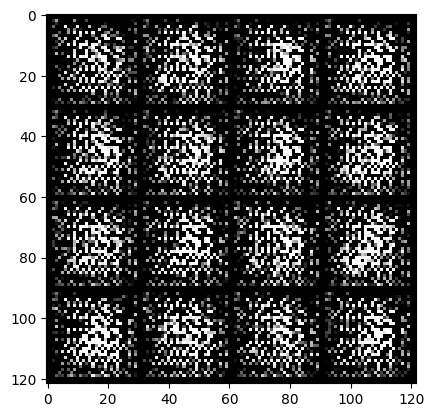

Epoch : 2 | D_loss : 0.6339490328516278 | G_loss : 0.7674682572452244


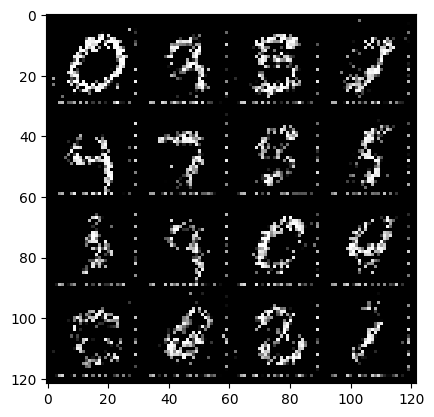

Epoch : 3 | D_loss : 0.6556488346697679 | G_loss : 0.7507807322656677


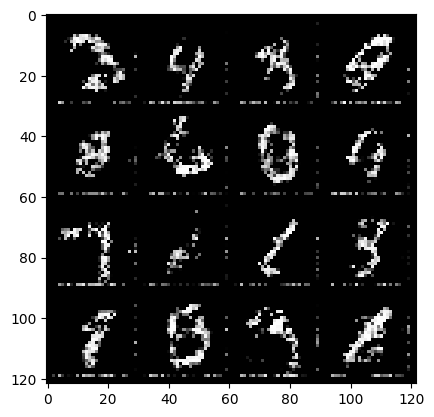

Epoch : 4 | D_loss : 0.6593486594238769 | G_loss : 0.7508725332044589


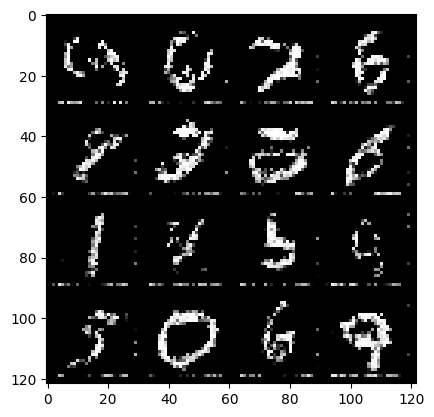

Epoch : 5 | D_loss : 0.6628692267037658 | G_loss : 0.7507351821165349


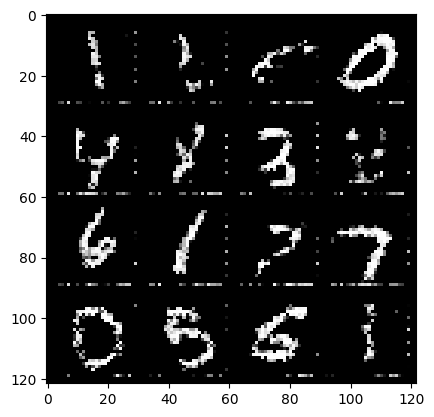

Epoch : 6 | D_loss : 0.6643592598341675 | G_loss : 0.7500364024247697


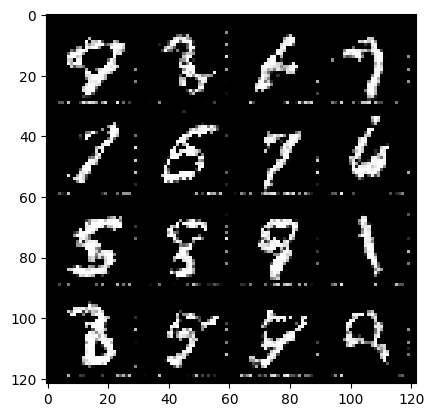

Epoch : 7 | D_loss : 0.6657954103656923 | G_loss : 0.7502575342589096


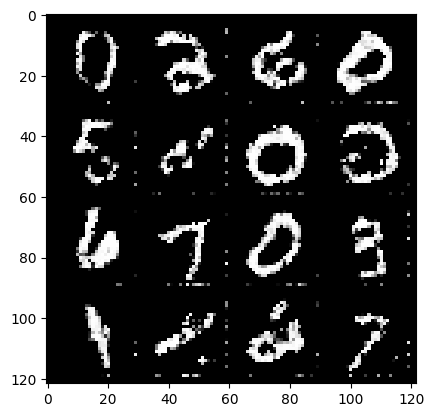

Epoch : 8 | D_loss : 0.6689061962211056 | G_loss : 0.7467283968732301


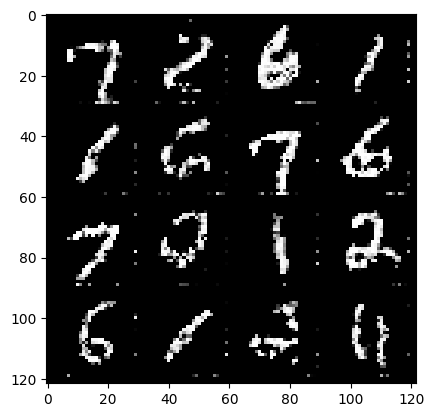

Epoch : 9 | D_loss : 0.6696701808524793 | G_loss : 0.7455697270598747


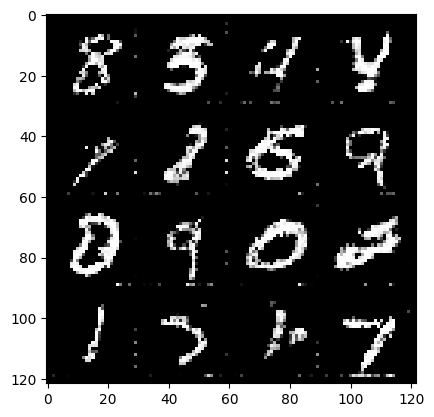

Epoch : 10 | D_loss : 0.6721883348818781 | G_loss : 0.7439596140816775


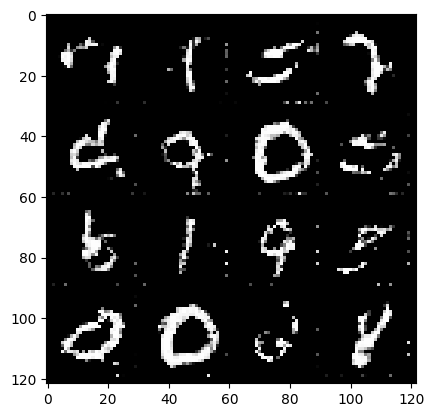

Epoch : 11 | D_loss : 0.6733029318262519 | G_loss : 0.7419621131059203


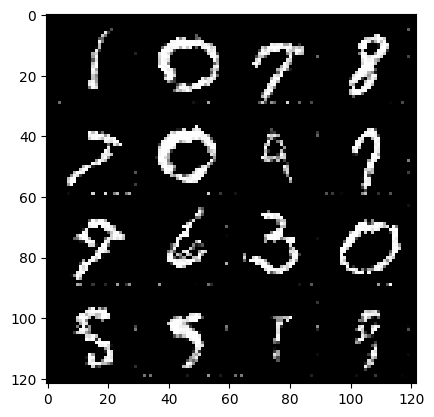

Epoch : 12 | D_loss : 0.6738900342729809 | G_loss : 0.7408738738692391


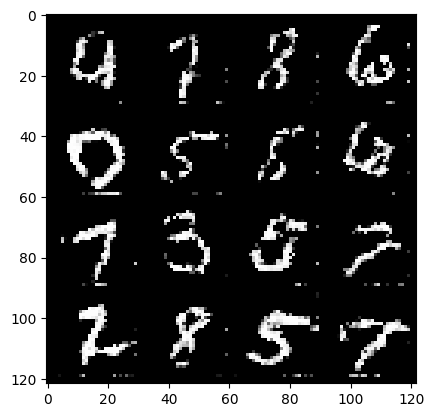

Epoch : 13 | D_loss : 0.6748577367776493 | G_loss : 0.7408160477050586


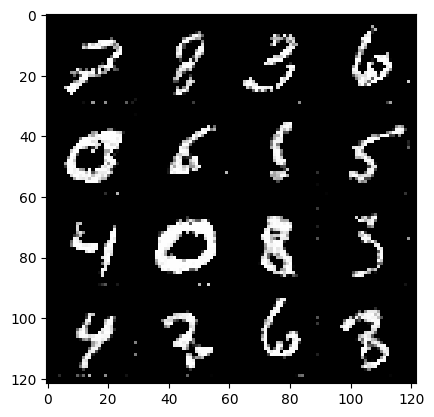

Epoch : 14 | D_loss : 0.6751847087955678 | G_loss : 0.7392838622715427


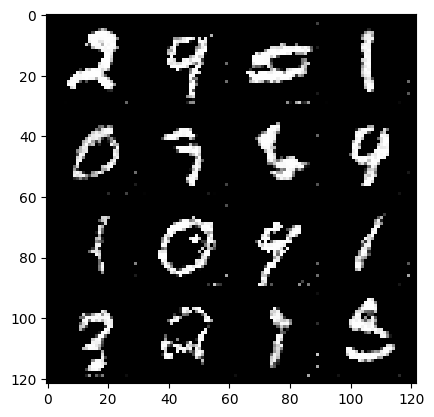

In [ ]:
import torch.nn as nn

def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)  # Fix the typo here
    loss = criterion(disc_pred, ground_truth)
    return loss

# Assuming you have defined the Generator (G) and Discriminator (D) elsewhere
# and you have created optimizers (D_opt and G_opt) for them

for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in trainloader:
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device=device)

        # Find loss and update weights for D
        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)
        D_loss = (D_fake_loss + D_real_loss) / 2

        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # Find loss and update weights for G
        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device=device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch : {} | D_loss : {} | G_loss : {}".format(i + 1, avg_d_loss, avg_g_loss))

    # Assuming you have a function show_tensor_images defined elsewhere
    show_tensor_images(fake_img)



